<a href="https://colab.research.google.com/github/davidcassagne/cours-iaphys/blob/main/chapter16_text_generation_3rd_edition_2025_04_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Third Edition](TODO). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

In [ ]:
!pip install keras-nightly keras-hub-nightly --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.8/803.8 kB 31.5 MB/s eta 0:00:00


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

### The potential of generative modeling

### A brief history of sequence generation

### Training a miniature GPT

In [ ]:
import keras
import pathlib

extract_dir = keras.utils.get_file(
    fname="mini-c4",
    origin=(
        "https://hf.co/datasets/mattdangerw/mini-c4/resolve/main/mini-c4.zip"
    ),
    extract=True,
)
extract_dir = pathlib.Path(extract_dir) / "mini-c4"

1505674161/1505674161 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


In [ ]:
os.listdir(extract_dir)

['shard2.txt', 'shard0.txt', 'shard3.txt', 'shard1.txt', 'shard4.txt']

In [ ]:
with open(extract_dir / "shard0.txt", "r") as f:
   print(f.readline().replace("\\n", "\n")[:100])

Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You


In [ ]:
import keras_hub
import numpy as np

vocabulary_file = keras.utils.get_file(
    origin="https://hf.co/mattdangerw/spiece/resolve/main/vocabulary.proto",
)
tokenizer = keras_hub.tokenizers.SentencePieceTokenizer(vocabulary_file)

499723/499723 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tokenizer.tokenize("The quick brown fox.")

Array([  450,  4996, 17354,  1701, 29916, 29889], dtype=int32)

In [ ]:
tokenizer.detokenize([450, 4996, 17354, 1701, 29916, 29889])

'The quick brown fox.'

In [ ]:
import tensorflow as tf

batch_size = 128
sequence_length = 256
suffix = np.array([tokenizer.token_to_id("<|endoftext|>")])

files = [extract_dir / file for file in os.listdir(extract_dir)]
ds = tf.data.TextLineDataset(files, num_parallel_reads=32)
ds = ds.map(
    lambda x: tf.strings.regex_replace(x, r"\\n", "\n"),
    num_parallel_calls=32,
)
ds = ds.map(tokenizer, num_parallel_calls=32)
ds = ds.map(lambda x: tf.concat([x, suffix], -1), num_parallel_calls=32)
ds = ds.rebatch(sequence_length + 1, drop_remainder=True)
ds = ds.map(lambda x: (x[:-1], x[1:]), num_parallel_calls=32)
ds = ds.batch(batch_size, num_parallel_calls=32).cache()

In [ ]:
num_batches = ds.reduce(0, lambda count, input: count + 1).numpy()
num_batches

np.int32(29373)

In [ ]:
num_val_batches = 500
num_train_batches = num_batches - num_val_batches
val_ds = ds.take(500)
train_ds = ds.skip(500).repeat()

#### Building the model

In [ ]:
from keras import layers

class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(
            num_heads, key_dim, dropout=0.1
        )
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        residual = x = inputs
        x = self.self_attention(query=x, key=x, value=x, use_causal_mask=True)
        x = self.dropout(x)
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = self.dropout(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

In [ ]:
from keras import ops

class PositionalEmbedding(keras.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
        super().__init__()
        self.token_embeddings = layers.Embedding(input_dim, output_dim)
        self.position_embeddings = layers.Embedding(sequence_length, output_dim)

    def call(self, inputs, reverse=False):
        if reverse:
            token_embeddings = self.token_embeddings.embeddings
            return ops.matmul(inputs, ops.transpose(token_embeddings))
        positions = ops.cumsum(ops.ones_like(inputs), axis=-1) - 1
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [ ]:
vocab_size = tokenizer.vocabulary_size()
hidden_dim = 512
intermediate_dim = 2056
num_heads = 8
num_layers = 8

inputs = keras.Input(shape=(None,), dtype="int32", name="inputs")
embedding = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)
x = embedding(inputs)
x = layers.LayerNormalization()(x)
for i in range(num_layers):
    x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(x)
outputs = embedding(x, reverse=True)
mini_gpt = keras.Model(inputs, outputs)

#### Pretraining the model

In [ ]:
class WarmupSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self):
        self.rate = 1e-4
        self.warmup_steps = 1_000.0

    def __call__(self, step):
        step = ops.cast(step, dtype="float32")
        scale = ops.minimum(step / self.warmup_steps, 1.0)
        return self.rate * scale

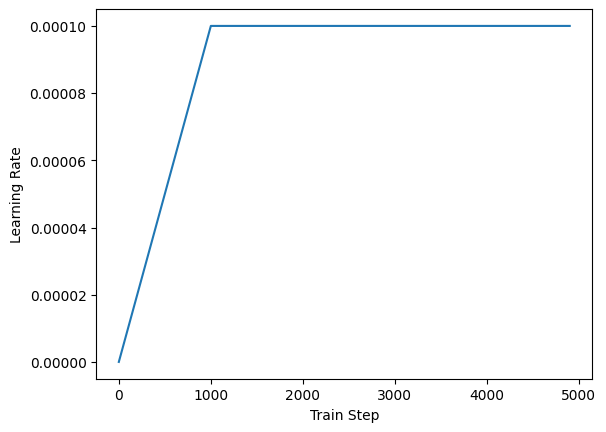

In [ ]:
import matplotlib.pyplot as plt

schedule = WarmupSchedule()
x = range(0, 5_000, 100)
y = [schedule(step) for step in x]
plt.plot(x, y)
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.savefig("learning-rate-warmup.png", dpi=300)

In [ ]:
num_passes = 2
num_epochs = 16
steps_per_epoch = num_train_batches * num_passes // num_epochs

mini_gpt.compile(
    optimizer=keras.optimizers.Adam(schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
mini_gpt.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/16


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4211081216 bytes.

#### Generative decoding

In [ ]:
def generate(prompt, max_length=64):
    tokens = list(tokenizer(prompt))
    prompt_length = len(tokens)
    for _ in range(max_length - prompt_length):
        prediction = mini_gpt(np.array([tokens]))
        prediction = prediction[0, -1]
        tokens.append(np.argmax(prediction).item())
    return tokenizer.detokenize(tokens)

In [ ]:
prompt = "A piece of advice"
generate(prompt)

In [ ]:
def compiled_generate(prompt, max_length=64):
    tokens = list(tokenizer(prompt))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        tokens[i] = np.argmax(prediction).item()
    return tokenizer.detokenize(tokens)

In [ ]:
import timeit
tries = 10
timeit.timeit(lambda: compiled_generate(prompt), number=tries) / tries

#### Sampling strategies

In [ ]:
def compiled_generate(prompt, sample_fn, max_length=64):
    tokens = list(tokenizer(prompt))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        next_token = sample_fn(prediction)
        tokens[i] = np.array(next_token).item()
    return tokenizer.detokenize(tokens)

In [ ]:
def greedy_search(preds):
    return ops.argmax(preds)

compiled_generate(prompt, greedy_search)

In [ ]:
def random_sample(preds, temperature=1.0):
    preds = preds / temperature
    return keras.random.categorical(preds[None, :], num_samples=1)[0]

In [ ]:
compiled_generate(prompt, random_sample)

In [ ]:
from functools import partial
compiled_generate(prompt, partial(random_sample, temperature=2.0))

In [ ]:
compiled_generate(prompt, partial(random_sample, temperature=0.8))

In [ ]:
compiled_generate(prompt, partial(random_sample, temperature=0.2))

In [ ]:
def top_k(preds, k=5, temperature=1.0):
    preds = preds / temperature
    top_preds, top_indices = ops.top_k(preds, k=k, sorted=False)
    choice = keras.random.categorical(top_preds[None, :], num_samples=1)[0]
    return ops.take_along_axis(top_indices, choice, axis=-1)

In [ ]:
compiled_generate(prompt, partial(top_k, k=5))

In [ ]:
compiled_generate(prompt, partial(top_k, k=20))

In [ ]:
compiled_generate(prompt, partial(top_k, k=5, temperature=0.5))

### Using a pretrained LLM

#### Prompting LLMs

In [ ]:
gemma_lm = keras_hub.models.CausalLM.from_preset("gemma_2b_en")

In [ ]:
gemma_lm.summary(line_length=80)

In [ ]:
gemma_lm.compile(sampler="greedy")
gemma_lm.generate("A piece of advice", max_length=64)

In [ ]:
gemma_lm.generate("How can I make brownies?", max_length=64)

In [ ]:
gemma_lm.generate(
    "The following brownie recipe is easy to make in just a few "
    "steps.\n\nYou can start by",
    max_length=64,
)

In [ ]:
gemma_lm.generate(
    "Tell me about the 61st president of the United States.",
    max_length=64,
)

#### Instruction fine-tuning an LLM

In [ ]:
import json

TEMPLATE = """"[instruction]
{instruction}[end]
[reponse]
{response}[end]"""

dataset_path = keras.utils.get_file(
    origin=(
        "https://hf.co/datasets/databricks/databricks-dolly-15k/"
        "resolve/main/databricks-dolly-15k.jsonl"
    ),
)
data = []
with open(dataset_path) as file:
    for line in file:
        features = json.loads(line)
        if features["context"]:
            continue
        data.append(TEMPLATE.format(**features))

In [ ]:
data[0]

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(data).shuffle(2000).batch(8)
val_ds = ds.take(100)
train_ds = ds.skip(100)

In [ ]:
preprocessor = gemma_lm.preprocessor
preprocessor.sequence_length = 512
batch = next(iter(train_ds))
x, y, sample_weight = preprocessor(batch)
x["token_ids"].shape

In [ ]:
x["padding_mask"].shape

In [ ]:
y.shape

In [ ]:
sample_weight.shape

In [ ]:
x["token_ids"][0, :5], y[0, :5]

#### Low-Rank Adaptation (LoRA) fine-tuning

In [ ]:
gemma_lm.backbone.enable_lora(rank=8)

In [ ]:
gemma_lm.summary(line_length=80)

In [ ]:
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(train_ds, validation_data=val_ds, epochs=1)

In [ ]:
gemma_lm.generate(
    "[instruction]\nHow can I make brownies?[end]\n"
    "[response]\n",
    max_length=512,
)

In [ ]:
gemma_lm.generate(
    "[instruction]\nWho is the 44th president of the United States?[end]\n"
    "[response]\n",
    max_length=512,
)

In [ ]:
gemma_lm.generate(
    "[instruction]\nWho is the 61st president of the United States?[end]\n"
    "[response]\n",
    max_length=512,
)

#### Reinforcement Learning with Human Feedback

#### Reinforcement Learning with Chain of Thought Reasoning

### Beyond text data

#### Extending an LLM for image input

In [ ]:
import matplotlib.pyplot as plt

image_url = (
    "https://github.com/mattdangerw/keras-nlp-scripts/"
    "blob/main/learned-python.png?raw=true"
)
image_path = keras.utils.get_file(origin=image_url)

image = keras.utils.load_img(image_path)
plt.axis("off")
plt.imshow(image)
plt.savefig("pali-gemma-test-image.png", dpi=300)

In [ ]:
pali_gemma_lm = keras_hub.models.CausalLM.from_preset("pali_gemma_3b_mix_448")

In [ ]:
pali_gemma_lm.summary(line_length=80)

In [ ]:
pali_gemma_lm.generate({
    "images": image,
    "prompts": "cap en\n",
})

In [ ]:
pali_gemma_lm.generate({
    "images": image,
    "prompts": "answer en where is the snake doing?\n",
})

In [ ]:
pali_gemma_lm.generate({
    "images": image,
    "prompts": "detect glasses\n",
})

In [ ]:
import re
import matplotlib.patches as patches

response = "<loc0280><loc0371><loc0380><loc0685> glasses"
box = [int(d) for d in re.findall(r"\d+", response)]
scale = image.shape[0] / 1024.0
y1, x1, y2, x2 = (c * scale for c in box)
width, height = x2 - x1, y2 - y1

fig, ax = plt.subplots()
ax.imshow(image)
ax.add_patch(
    patches.Rectangle(
        (x1, y1), width, height, linewidth=1, edgecolor="r", facecolor="none"
    )
)
plt.axis("off")
plt.savefig("pali-gemma-detect-box.png", dpi=300, bbox_inches="tight")

#### Retrieval Augmented Generation

#### Foundation models

### Where are LLMs heading next?

### Chapter Summary